In [1]:
from spine.spine_exam import SpineStudy
from spine.read import read_study
from spine.visualisation.interactive import interactive_visualization, simple_interactive
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import torchvision.transforms.functional as tf
import torch.nn.functional as F
%matplotlib widget

In [2]:
import torch
import torch.nn as nn
from pathlib import Path

import random
import numpy as np
import pandas as pd
import os

import pandas as pd
import torch.utils
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from spine.model.model import RSNASpineLightningModule
from spine.task.dataset import SpinePredictDataset, custom_collate_fn, SpineDataset
from spine.task.tables import read_train_tables


import pytorch_lightning as pl
import os
import math


def _to_path_or_none(path):
    return Path(path) if path is not None else None

dataset_path =  _to_path_or_none(os.environ.get("SPINE_DATASET")) or Path("/home/mkurtys/projects/datasets/spine")
checkpoint = _to_path_or_none(os.environ.get("CHECKPOINT")) or Path("checkpoints/last-v1.ckpt")

# Set random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Read the tables
descriptions = pd.read_csv(dataset_path/"test_series_descriptions.csv")
model = RSNASpineLightningModule.load_from_checkpoint(checkpoint)
model.eval()

descriptions, coordinates, train_melt, train = read_train_tables(dataset_path)

train_spine_dataset = SpineDataset(dicom_dir=dataset_path/"train_images/",
                                train=train,
                                coordinates=coordinates,
                                descriptions=descriptions,
                                resize=(224,224),
                                transform=None,
                                )

sample = train_spine_dataset[0]
sample = custom_collate_fn([sample])
#sample = {key: value[0] for key, value in sample.items()}


/home/mkurtys/.pyenv/versions/3.11.1/envs/spine/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [38]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(0.1, 0.1), contrast_limit=(0.2, 0.2), p=1.0),
    A.GaussNoise(var_limit=(0.01, 0.05), p=1.0),
    # A.GaussianBlur(blur_limit=5)
    A.MotionBlur(blur_limit=5),
    #A.OneOf([
    #    A.MotionBlur(blur_limit=5),
    #    A.MedianBlur(blur_limit=5),
    #    A.GaussianBlur(blur_limit=5),
    #    A.GaussNoise(var_limit=(5.0, 30.0)),
    #], p=1.0),
])

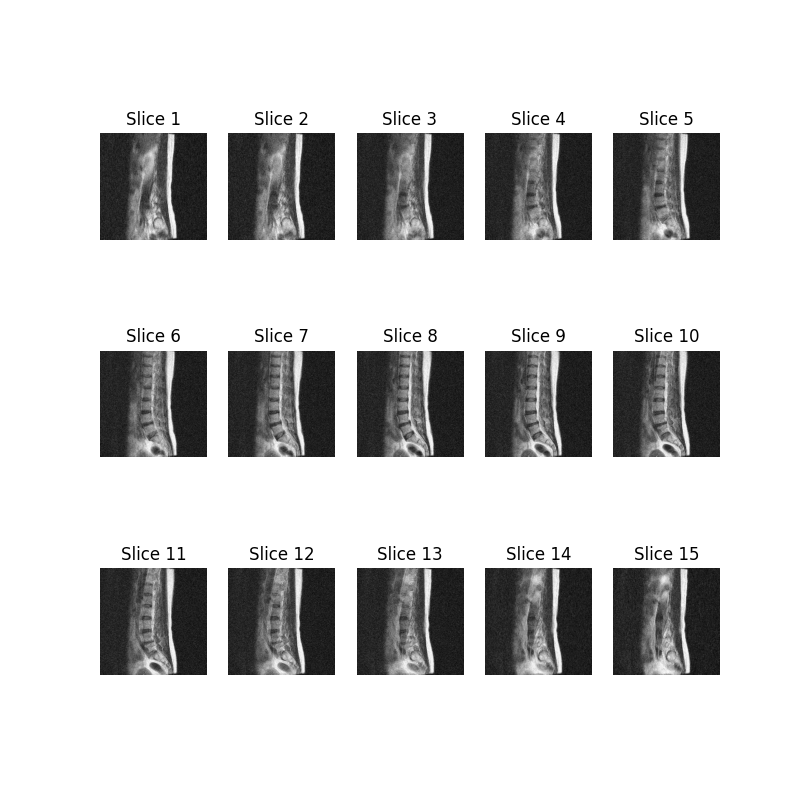

In [39]:
volume = sample["image"]
volume = volume.detach().cpu().numpy().astype(np.float32) # b["image"][:b["D"][0], ...].detach()
volume = transforms_train(image=volume)["image"]
n_slices = 15
fig, axs = plt.subplots(3,5, figsize=(8,8))
stride = math.ceil(volume.shape[0]/n_slices)
for i, slice_idx in enumerate(range(0, volume.shape[0], stride)):
    ax = axs.flatten()[i]
    low = slice_idx
    high = min(volume.shape[0], slice_idx+stride)
    thick_slice = volume[low:high].mean(0)
    ax.imshow(thick_slice, cmap='gray')
    ax.set_title(f'Slice {slice_idx+1}')
    ax.axis('off')